<a href="https://colab.research.google.com/github/Joshua1030/APS360_Team17/blob/main/Primary_model_johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Loading and Splitting
Download data from kaggle and split them into train, validation, and test sets. Data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

Since the dataset contains about 10,000 images over 6 categories, it will take very long to train our model. Our team decide to randomly choose 500 images for training, 100 images for validation, and 100 images for testing, from each category. 
Datasets can be downloaded by link: https://drive.google.com/drive/folders/1vMEit7Gcn2ZQd1DnRtb2J6Gn7FbUQP4T?usp=share_link

In [1]:
#import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#make sure to use the correct address

train_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Train"
val_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Val"
test_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Test"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
classes = ('freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges')

#resize all images to 224x224
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                ])
#transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
trainset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
valset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(test_dir, transform=transform)


#data loader
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, num_workers=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=16, num_workers=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, num_workers=8, shuffle=False)

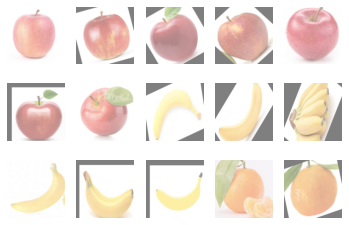

In [ ]:
#Visualize data
k = 0
for images, labels in val_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    #print(labels)
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

Primary Model

### Convolutional Neural Network Architecture

In [ ]:
#Convolutional Neural Network Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 96,kernel_size=11,stride=4,padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            
            nn.Conv2d(96, 256,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            
            nn.Conv2d(256,384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384,384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            
            nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(1024,4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096,1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000,6)   
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

### Set random seed for code reproducibility

In [ ]:
def set_seed(seed=2022):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark=False
    torch.backends.cudnn.deterministic=True

### Train and test function

In [ ]:
def train(model, train_loader, valid_loader=None, num_epochs=50, learning_rate=1e-4):
    """ Training loop. You should update this."""
    set_seed()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_list, train_acc_list, val_acc_list = [], [], []
    
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        avg_loss = 0
        for idx,(imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
    
            out = model(imgs)             # forward computation
            loss = criterion(out, labels) # compute the average batch loss
            optimizer.zero_grad()         # set all variable's grad equal to 0
            loss.backward()               # BP (compute parameter updates)
            optimizer.step()              # parameters update
            avg_loss += loss.item()  
        
        # save the current training information
        avg_loss /= len(train_loader)           
        train_acc = test(model,train_loader) # compute training accuracy 
        val_acc = test(model,val_loader)  # compute validation accuracy
        
        loss_list.append(avg_loss)  
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f'In epoch {epoch},training accuray is {np.round(train_acc,4)},validation accuracy is {np.round(val_acc,4)},\
        average loss is {np.round(avg_loss,4)}')
    return loss_list,train_acc_list,val_acc_list

def test(model,test_loader):
    model.eval()
    total_correct = 0
    num_labels = 0
    with torch.no_grad():
        for idx,(imgs,labels) in enumerate(test_loader):
            imgs = imgs.to(device)
            out = model(imgs)
            pred = torch.max(out,dim=1)[1]
            correct = (pred.data.cpu()==labels).sum().item()
            total_correct += correct
            num_labels += imgs.shape[0]
    acc = total_correct/num_labels
    return acc

### Find best hyper-parameters 

In [ ]:
loss_record,train_acc_record,val_acc_record = [],[],[]
for lr in [1e-3,1e-4,1e-5]:
    print(f'when learning rate is {lr}:')
    fruit = CNN()
    loss,train_acc,val_acc = train(fruit, train_loader,valid_loader=val_loader,learning_rate=lr)
    loss_record.append(loss)
    train_acc_record.append(train_acc)
    val_acc_record.append(val_acc)
    
    print('\n')

when learning rate is 0.001:
In epoch 0,training accuray is 0.4023,validation accuracy is 0.405,        average loss is 1.4657
In epoch 1,training accuray is 0.7027,validation accuracy is 0.6667,        average loss is 1.0828
In epoch 2,training accuray is 0.7513,validation accuracy is 0.7067,        average loss is 0.7541
In epoch 3,training accuray is 0.8537,validation accuracy is 0.8317,        average loss is 0.7138
In epoch 4,training accuray is 0.8153,validation accuracy is 0.8,        average loss is 0.5901
In epoch 5,training accuray is 0.8127,validation accuracy is 0.7817,        average loss is 0.5541
In epoch 6,training accuray is 0.86,validation accuracy is 0.8367,        average loss is 0.4845
In epoch 7,training accuray is 0.8917,validation accuracy is 0.8717,        average loss is 0.403
In epoch 8,training accuray is 0.8197,validation accuracy is 0.78,        average loss is 0.3432
In epoch 9,training accuray is 0.901,validation accuracy is 0.8617,        average loss i

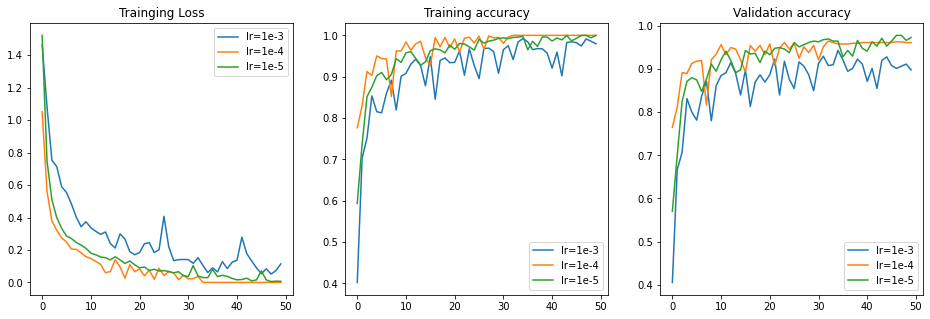

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].plot(loss_record[0],label=f'lr=1e-3')
ax[0].plot(loss_record[1],label=f'lr=1e-4')
ax[0].plot(loss_record[2],label=f'lr=1e-5')
ax[0].set_title('Trainging Loss')
ax[0].legend()

ax[1].plot(train_acc_record[0],label=f'lr=1e-3')
ax[1].plot(train_acc_record[1],label=f'lr=1e-4')
ax[1].plot(train_acc_record[2],label=f'lr=1e-5')
ax[1].set_title('Training accuracy')
ax[1].legend()

ax[2].plot(val_acc_record[0],label=f'lr=1e-3')
ax[2].plot(val_acc_record[1],label=f'lr=1e-4')
ax[2].plot(val_acc_record[2],label=f'lr=1e-5')
ax[2].set_title('Validation accuracy')
ax[2].legend()

plt.show()

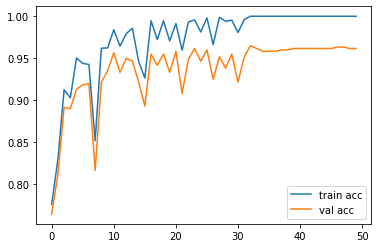

In [ ]:
plt.plot(train_acc_record[1],label='train acc')
plt.plot(val_acc_record[1],label='val acc')
plt.legend()
plt.show()

In [ ]:
fruit = CNN()
train(fruit, train_loader,val_loader,num_epochs=40,learning_rate=1e-4)

In epoch 0,training accuray is 0.7763,validation accuracy is 0.765,        average loss is 1.0521
In epoch 1,training accuray is 0.8297,validation accuracy is 0.8117,        average loss is 0.5632
In epoch 2,training accuray is 0.9127,validation accuracy is 0.8917,        average loss is 0.379
In epoch 3,training accuray is 0.903,validation accuracy is 0.89,        average loss is 0.3213
In epoch 4,training accuray is 0.9503,validation accuracy is 0.9133,        average loss is 0.2748
In epoch 5,training accuray is 0.944,validation accuracy is 0.9183,        average loss is 0.249
In epoch 6,training accuray is 0.9427,validation accuracy is 0.92,        average loss is 0.2055
In epoch 7,training accuray is 0.852,validation accuracy is 0.8167,        average loss is 0.2036
In epoch 8,training accuray is 0.962,validation accuracy is 0.9217,        average loss is 0.1829
In epoch 9,training accuray is 0.9623,validation accuracy is 0.935,        average loss is 0.1589
In epoch 10,training a

In [ ]:
acc = test(fruit,test_loader)
print(f'The best model\'s testing accuracy is {np.round(acc,4)}')

The best model's testing accuracy is 0.97
